In [1]:
import numpy as np
import pandas as pd
import low_rank_models as lrm
import matplotlib.pyplot as plt

In [2]:
large_df = pd.read_csv('error_matrix.csv', index_col=0)
large_models = np.array(list(large_df))
large_IDs = large_df.index.values
large_EM = large_df.values
large_ndatasets, large_nmodels = large_EM.shape

In [3]:
small_df = pd.read_csv('error_matrix_small.csv', index_col=0)
small_models = np.array(list(small_df))
small_IDs = small_df.index.values
small_EM = small_df.values
small_ndatasets, small_nmodels = small_EM.shape

# Select only rows corresponding to datasets common to both error matrices
small_EM = small_EM[np.in1d(small_IDs, large_IDs),:]

In [4]:
# Columns of large error matrix that are contained in small error matrix
LARGE_IN_SMALL = np.array([1,3,5,7,9,11,38,26,51,52,53,54,59,60,61,62,106,107,108,109,111,122,164,168,165,169,123]).astype(int)

# Columns of small error matrix that are not contained in small error matrix
SMALL_NOTIN_LARGE = np.array([6,7,8,9,12,15,20,34,35,36,37,38]).astype(int)

In [16]:
larger_EM = np.hstack((large_EM, small_EM[:,SMALL_NOTIN_LARGE]))
larger_ndatasets, larger_nmodels = larger_EM.shape

In [6]:
N_DATASETS = min(large_ndatasets, small_ndatasets)
MAX_RANK = small_nmodels - 1

In [7]:
MSE_small = np.zeros(MAX_RANK)

for j in range(MAX_RANK):
    rank = j + 1
    total_loss = 0
    
    for i in range(N_DATASETS):
        a = small_EM[i].reshape(1,-1)
        A = np.delete(small_EM, i, axis=0)
        a_hat = np.zeros((1, small_nmodels))
        X,Y = lrm.pca(A, rank)
        known = lrm.pivoted_qr(Y)[:rank]
        a_hat[:,known] = a[:,known]
        a_hat = lrm.low_rank_approximation(A, a_hat, known)
        total_loss += np.linalg.norm(a - a_hat)
    
    MSE_small[j] = total_loss/N_DATASETS

In [17]:
MSE_large = np.zeros(MAX_RANK)
SUB_INDICES = np.concatenate((LARGE_IN_SMALL, np.arange(large_nmodels, larger_EM.shape[1])))

for j in range(MAX_RANK):
    rank = j + 1
    total_loss = 0
    
    for i in range(N_DATASETS):
        a = larger_EM[i].reshape(1,-1)
        A = np.delete(larger_EM, i, axis=0)
        a_hat = np.zeros((1, larger_nmodels))
        X,Y = lrm.pca(A, rank)
        known = SUB_INDICES[lrm.pivoted_qr(Y[:,SUB_INDICES])][:rank]
        a_hat[:,known] = a[:,known]
        a_hat = lrm.low_rank_approximation(A, a_hat, known)
        total_loss += np.linalg.norm(a - a_hat)
        
    MSE_large[j] = total_loss/N_DATASETS

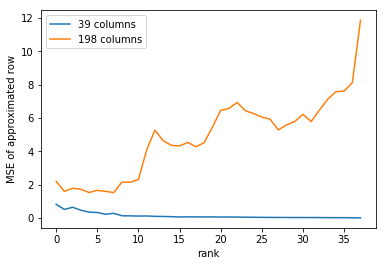

In [21]:
x = np.arange(MAX_RANK)
plt.plot(x, MSE_small, label='39 columns')
plt.plot(x, MSE_large, label='198 columns')
plt.legend(loc='upper left')
plt.xlabel('rank')
plt.ylabel('MSE of approximated row')
plt.show()